In [1]:
!pip install umap-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from xgboost import XGBClassifier as XGB
from  umap import UMAP
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM as ocsvm
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, MaxPooling2D, Multiply, Input, LSTM, GRU, ZeroPadding2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.activations import relu
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import kmeans_plusplus

In [3]:
@keras.saving.register_keras_serializable()
class DataGenerator(tf.keras.layers.Layer):
  """Transform  signal into 2D image
  img_shape :  Shape of transformed image
  n_f : No of features
  """

  def __init__(self, img_shape, n_f):
    super(DataGenerator, self).__init__()
    self.img_shape = img_shape
    self.n_f = n_f

  @tf.function
  def call(self, inputs):
    batch_size = tf.shape(inputs)[0]
    fft_sig = tf.signal.fft(tf.cast(inputs, tf.complex64))
    fft_real = tf.math.real(fft_sig)
    fft_imag = tf.math.imag(fft_sig)
    fft_img_real = tf.reshape(fft_real,  shape = (batch_size, self.img_shape[0], self.img_shape[1], self.n_f))
    fft_img_imag = tf.reshape(fft_imag, shape = (batch_size,self.img_shape[0], self.img_shape[1], self.n_f))
    inputs_img = tf.reshape(inputs, shape = (batch_size,self.img_shape[0], self.img_shape[1], self.n_f))
    return tf.concat([fft_img_real, fft_img_imag, inputs_img], axis  = -1)

  def get_config(self):
    config = super(DataGenerator, self).get_config()
    config.update({'img_shape':self.img_shape, 'n_f':self.n_f})
    return config

  def compute_output_shape(self, input_shape):
    return (None, self.img_shape[0], self.img_shape[1], 3*self.n_f)
  @classmethod
  def from_config(cls, config):
    return cls(**config)

@keras.saving.register_keras_serializable()
class DataReverser(tf.keras.layers.Layer):
  """Transform 2D image into signal
  T_x : NO of timesteps
  n_f : NO of feaTures
  batch_size : No of examples in single batch"""

  def __init__(self, T_x, n_f, batch_size):
    super(DataReverser, self).__init__()
    self.T_x = T_x
    self.n_f = n_f

  @tf.function
  def call(self, inputs):
    splitted_image = tf.split(inputs,num_or_size_splits = 3 ,axis = -1)
    inputs_img = splitted_image[2]
    inputs_array = tf.reshape(inputs_img, shape = (-1, self.T_x, self.n_f))

    return inputs_array

  def get_config(self):
    config = super(DataReverser, self).get_config()
    config.update({"T_x":self.T_x, "n_f":self.n_f})
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

@keras.saving.register_keras_serializable()
class Conv_layer(tf.keras.layers.Layer):
  """Conv_layer for feature extaraction from 2D image of signal
  conv_model : Convolutional model(Custom)
  autoencoder_status = True if conv_model is autoencoder
  """

  def __init__(self, conv_model, autoencoder_status):
    super(Conv_layer, self).__init__()
    self.conv_model = conv_model
    self.conv_model_config = conv_model.to_json()
    self.conv_input = conv_model.input
    #Checking for AutoEncoder status because autoencoder require different conditioning of pre_xgb_model
    if autoencoder_status:
      try:
        self.conv_output = conv_model.get_layer("Middle").output
      except:
        raise MissingLayerName(f""" The layer name "Middle" is not found in the conv_model
                                   ///Ensure that provided conv model has a layer named Middle
                                   'Middle Layer is bottleneck layer
                                   If you are Making ConvLSTM then "Middle" should be the name of extra layer after LSTM output"
                                    """)  from None
    else:
      try:
        self.conv_output = conv_model.get_layer("Flatten").output
      except :
        raise MissingLayerName(f""" The layer name "Flatten" is not found in the conv_model
                                   ///The provided model must include a 'Flatten' layer if it is not an autoencoder.
                                   'Flatten Layer Flattens the input. Does not affect the batch size.' """)  from None
    #Creating a model
    self.pre_xgb_model = Model(inputs = [self.conv_input], outputs = [self.conv_output])

  @tf.function
  def call(self, inputs):
    return self.conv_model(inputs)


  def get_config(self):
    config = super(Conv_layer, self).get_config()
    config.update({'conv_model_config':self.conv_model_config})
    return config

  def compute_output_shape(self, input_shape):
    return self.conv_model.output_shape

  @classmethod
  def from_config(cls, config):
    return cls(**config)

@keras.saving.register_keras_serializable()
class ConvXGB_layer(tf.keras.layers.Layer):
  """Layer for joining conv_model with XGB model
  XGB_model : Custom XGB model
  pre_xgb_model : Model containing input layer, datagenerator layer with modified version of a convolutional neural network (CNN),
  designed to extract features from an intermediate or flatten layer of the
  original model depending on the autoencoder_status"""

  def __init__(self, XGB_model, pre_xgb_model):
    super(ConvXGB_layer, self).__init__()
    self.XGB_model = XGB_model
    self.pre_xgb_model = pre_xgb_model


  def _train_forest(self, Conv_stored, y_train):
    self.XGB_model.fit(Conv_stored, y_train)


  def get_config(self):
    config = super().get_config()
    config.update({'pre_xgb_model_config': self.pre_xgb_model.to_json(), 'XGB_param':self.XGB_model.get_params()})
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

@keras.saving.register_keras_serializable()
class ConvISO_layer(tf.keras.layers.Layer):
  """Layer for joining conv_model with Isolation Forest model
  ISO_model : Custom Isolation model
  pre_iso_model : Model containing input layer, datagenerator layer with modified version of a convolutional neural network (CNN),
  designed to extract features from an intermediate or flatten layer of the
  original model depending on the autoencoder_status"""

  def __init__(self, ISO_model, pre_iso_model):
    super(ConvISO_layer, self).__init__()
    self.ISO_model = ISO_model
    self.pre_iso_model = pre_iso_model

  def _train_forest(self, conv_stored):
    return self.ISO_model.fit(conv_stored)

  def get_config(self):
    config = super().get_config()
    config.update({"ISO_model_config":self.pre_iso_model.get_params(), "pre_iso_model_config":self.pre_iso_model.to_json()})
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

@keras.saving.register_keras_serializable()
class ConvSVM_layer(tf.keras.layers.Layer):
  """Layer for joining conv_model with SVM model
  SVM_model : Custom SVM model
  pre_svm_model : Model containing input layer, datagenerator layer with modified version of a convolutional neural network (CNN),
  designed to extract features from an intermediate or flatten layer of the
  original model depending on the autoencoder_status"""

  def __init__(self, SVM_model, pre_svm_model):
    super(ConvSVM_layer, self).__init__()
    self.SVM_model = SVM_model
    self.pre_svm_model = pre_svm_model

  def _train_SVM(self, conv_stored):
    return self.SVM_model.fit(conv_stored)

  def get_config(self):
    config = super().get_config()
    config.update({"pre_SVM_config":2, "pre_svm_model_config":self.pre_svm_model.to_json()})
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class InvalidDimensions(Exception):
  "Exception for Invalid dimensioning of Model"
  pass

class NotImplemented(Exception):
  "Exception raised when requierd method or layer intialization is missing"
  pass

class MissingLayerName(Exception):
  "Exception for handling for missing parameters in Conv_layer."
  pass

In [4]:
class IFD:
  """Attributes:
  transformed_img_shape:
  n_f:
  T_x:
  num_pred:
  batch_size:
  replace_part:"""

  def __init__(self, transformed_img_shape, n_f, T_x,  num_pred, batch_size = 32, replace_part = True) -> None:
    self.transformed_img_shape = transformed_img_shape
    self.n_f = n_f
    self.T_x = T_x
    self.num_pred= num_pred
    self.batch_size = batch_size
    self.replace_part = replace_part

  def set_conv_layer(self, conv_model, auto_encoder = False) -> None:
    """Creates conv_layer
    conv_model : Custom convolutional model
    auto_encoder = True if conv_model has an autoencoder architecture"""
    self.conv_layer = Conv_layer(conv_model, auto_encoder)
    self.conv_model_input = conv_model.input_shape
    self.conv_model_output = conv_model.output_shape
    self.auto_encoder_status = auto_encoder
    print("conv_layer is created")

  def set_Data_generator(self) ->None:
    """Creates DataGenerator Layer"""
    self.data_generator = DataGenerator(self.transformed_img_shape, self.n_f)
    self.data_generator_output = self.data_generator.compute_output_shape((self.batch_size, self.T_x, self.n_f))
    print("DataGenerator is created")
######################################################################################################################################################################
  def conditions_check(self)  -> bool:
    "Method to check conditions for proper alignment of different layers together"
    N, M = self.transformed_img_shape
    if N*M != self.T_x:
      raise InvalidDimensions(f"Size of Image should match the time step length of signal {N*M} != {self.T_x}")
    if not hasattr(self, "conv_model_input"):
      raise NotImplemented(f"""First initialize the conv layer using {type(self).__name__}.set_conv_layer() method.
       IFD's object has no attribute with name conv_model_input""")

    if not hasattr(self, "data_generator_output"):
      raise NotImplemented(f"First initialize the Data Generator Layer using {type(self).__name__}.set_Data_Generator() method")

    if not hasattr(self, "conv_model_output"):
      raise NotImplemented(f"First initialize the conv layer using {type(self).__name__}.set_conv_layer() method")

    if self.conv_model_input != self.data_generator_output:
      raise InvalidDimensions(f"Input of Conv model doesn't match the output of DataGenerator Layer//{self.conv_model_input}!= {self.data_generator_output}")

    if self.auto_encoder_status == False and self.conv_model_output[-1] != self.num_pred:
      if len(self.conv_model_output)!= 2:
        raise NotImplemented(f"""//Please do auto_encoder == True if you are using auto encoder architecture for unsupervised learning""")
      else:
        raise InvalidDimensions(f"conv_model_output should be equal to the num of predictions in this case {self.num_pred}")

    if self.auto_encoder_status == True and self.conv_model_output != self.conv_model_input:
      raise InvalidDimensions(f"Output shape  of conv model should be equal to input shape for autoencoder// In these Case {self.conv_model_output} != {self.conv_model_input}")

    ###Checking conditions for AutoEncoder
    ##TO DO
    if self.auto_encoder_status == True:
      pass
    return True
##########################################################################################################################################################################
  def create_and_train_ConvXGB(self, created_model, XGB_model, X_train, y_train) :

    """Use this method after trainig to remove the fnn layer and fit XGB model
    created_model : Main model created by using create_model method
    XGB_model : Custom XGB model
    X_train : Training dataset containing input featuers for model to learn
    y_train : Training dataset containing labels  for model to learn"""

    if self.replace_part == True and created_model.weights:
      pre_xgb_generator = DataGenerator(self.transformed_img_shape, self.n_f)
      #Creating ConvXGB model
      inp = Input(shape = (self.T_x, self.n_f), name = "Inputs")
      generated_data = pre_xgb_generator(inp)

      if self.auto_encoder_status == True:
        pre_xgb_model = created_model.get_layer(index = -2).pre_xgb_model
        conv_output = pre_xgb_model(generated_data)
        conv_output_flatten = Flatten()(conv_output[0]) #Flattening after middle layer in autoencoder for fitting xgb model
        side_xgb_model = Model(inputs = [inp], outputs = [conv_output_flatten])
        side_xgb_model.summary()
        Conv_stored = side_xgb_model(X_train)
      else:
        pre_xgb_model = created_model.get_layer(index = -1).pre_xgb_model
        conv_output = pre_xgb_model(generated_data)
        side_xgb_model = Model(inputs = [inp], outputs = [conv_output])
        side_xgb_model.summary()
        Conv_stored = side_xgb_model(X_train)[0]

      ConvXGB = ConvXGB_layer(XGB_model, side_xgb_model)
      Conv_stored = tf.numpy_function(func = lambda x : np.array(x), inp = [Conv_stored], Tout = tf.float32)
      ConvXGB._train_forest(Conv_stored, y_train)


    else:
      print("Model is not trained yet//Trained Model is important for creating ConvXGB")

    return ConvXGB

  def create_and_train_ConvISO(self, created_model, ISO_model, X_train):
    """Use this method after trainig to remove the fnn layer and fit XGB model
    created_model : Main model created by using create_model method
    ISO_model : Custom Isolation model
    X_train : Training dataset containing input featuers for model to learn """

    if self.replace_part== True and created_model.weights:
      pre_iso_generator = DataGenerator(self.transformed_img_shape, self.n_f)
      #Creating ConvISO model
      inp = Input(shape = (self.T_x, self.n_f), name = "Inputs")
      generated_data = pre_iso_generator(inp)

      if self.auto_encoder_status == True:
        pre_iso_model = created_model.get_layer(index = -2).pre_xgb_model
        conv_output = pre_iso_model(generated_data)
        conv_output_flatten = Flatten()(conv_output[0])
        side_iso_model = Model(inputs = [inp], outputs = [conv_output_flatten])
        Conv_stored = side_iso_model(X_train)
      else:
        pre_iso_model = created_model.get_layer(index = -1).pre_xgb_model
        conv_output = pre_iso_model(generated_data)
        side_iso_model = Model(inputs = [inp], outputs = [conv_output])
        side_iso_model.summary()
        Conv_stored = side_iso_model(X_train)[0]

      ConvISO = ConvISO_layer(ISO_model, side_iso_model)
      Conv_stored = tf.numpy_function(func = lambda x : np.array(x), inp = [Conv_stored], Tout = tf.float32)
      ConvISO._train_forest(Conv_stored)
    else:
      print("Model is not trained yet//Trained Model is important for creating ConvXGB")

    return ConvISO


  def create_and_train_ConvSVM(self, created_model, SVM_model, X_train):
    """Use this method after trainig to remove the fnn layer and fit XGB model
    created_model : Main model created by using create_model method
    SVM_model : Custom SVM model
    X_train : Training dataset containing input featuers for model to learn """

    if self.replace_part  == True and created_model.weights:
      pre_svm_generator = DataGenerator(self.transformed_img_shape, self.n_f)
      #Creating ConvSVM model
      inp = Input(shape = (self.T_x, self.n_f), name = "Inputs")
      generated_data = pre_svm_generator(inp)

      if self.auto_encoder_status == True:
        pre_svm_model = created_model.get_layer(index = -2).pre_xgb_model
        conv_output = pre_svm_model(generated_data)
        conv_output_flatten = Flatten()(conv_output[0])
        side_svm_model = Model(inputs = [inp], outputs = [conv_output_flatten])
        Conv_stored = side_svm_model(X_train)
      else:
        pre_svm_model = created_model.get_layer(index = -1).pre_xgb_model
        conv_output = pre_svm_model(generated_data)
        side_svm_model = Model(inputs = [inp], outputs = [conv_output])
        side_svm_model.summary()
        Conv_stored = side_svm_model(X_train)[0]

      ConvSVM = ConvSVM_layer(SVM_model, side_svm_model)
      Conv_stored = tf.numpy_function(func = lambda x : np.array(x), inp = [Conv_stored], Tout = tf.float32)
      ConvSVM._train_SVM(Conv_stored)
    else:
      print("Model is not trained yet//Trained Model is important for creating ConvXGB")

    return ConvSVM

  def create_model(self):
    #Input layer
    inp = Input(shape = (self.T_x, self.n_f), name = "Inputs")
    #Checking all conditions
    if self.conditions_check():
      print("DataGenerator and Conv_layer is merged")
    #Data generator
    generated_data = self.data_generator(inp)
    conv_output = self.conv_layer(generated_data)
    if self.auto_encoder_status == True:
      rev_conv_output = DataReverser(self.T_x, self.n_f, self.batch_size)(conv_output)
      model = Model(inputs = [inp], outputs = [rev_conv_output])
    else:
      model = Model(inputs = [inp], outputs = [conv_output])

    return model

###Preparing Dataset

In [5]:
data = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
data.shape

(4998, 141)

In [6]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [7]:
train_data, test_data = train_test_split(data, test_size = 0.2, shuffle = True)

In [8]:
train_data

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
2737,-0.856122,-3.742023,-4.646538,-4.859646,-4.186356,-3.360995,-2.228998,-1.570431,-0.908053,0.022593,...,0.555969,1.066785,1.181102,1.374775,1.291138,1.154463,1.453046,1.493624,-1.280764,1.0
2941,-2.953014,-5.180724,-4.861610,-4.181026,-2.662396,-1.852387,-1.454710,-0.813677,-0.439736,-0.514875,...,1.220478,1.260690,1.067819,0.821500,0.547064,0.961518,1.464368,0.982073,-1.315325,1.0
3982,0.168123,-0.378892,-0.765560,-1.421835,-1.834293,-2.164088,-2.385832,-2.244670,-2.002563,-1.763869,...,-2.249159,-2.860742,-3.482268,-3.810311,-3.965749,-3.399206,-2.428885,-1.974958,-0.486390,0.0
3894,-1.144542,-2.229040,-2.726501,-3.194187,-3.592152,-3.640512,-3.517366,-3.464565,-3.390506,-3.191846,...,0.417268,0.425358,0.375604,0.425806,0.587570,0.527167,0.181018,0.154666,0.840704,0.0
251,2.965216,-1.383973,-3.435806,-4.205791,-3.706039,-2.562112,-1.046464,-0.466539,-0.101435,0.889877,...,-0.017969,0.059906,0.273267,0.464971,0.266427,0.385604,0.557800,1.653071,-1.210887,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2638,-1.310992,-2.907922,-3.610170,-3.906445,-3.473987,-2.490383,-1.644679,-1.596164,-0.995596,-0.553181,...,1.236231,1.381590,1.245311,1.242481,1.278818,1.311670,1.508227,1.533240,0.597757,1.0
1061,-1.784607,-3.388158,-3.248682,-3.488572,-3.193728,-2.578181,-1.767984,-1.565201,-1.399333,-0.859726,...,1.559589,1.786096,1.737391,1.549225,1.245990,1.244538,1.546268,1.444361,-0.063030,1.0
4772,-0.595587,-1.980611,-2.893643,-3.123109,-3.038011,-2.715843,-2.241221,-1.684011,-1.102957,-0.802963,...,-0.764769,-1.216729,-1.910224,-2.729466,-3.810843,-4.111980,-3.167672,-2.077722,-1.409541,0.0
2469,1.223315,0.138861,-1.890271,-3.334858,-4.103713,-4.191581,-3.001530,-2.149222,-1.980692,-1.134918,...,0.205455,0.752658,0.835911,1.602804,1.956546,2.004274,1.080754,0.621642,1.080445,1.0


In [9]:
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
X_train

array([[0.50217339, 0.31677689, 0.06235309, ..., 0.76570009, 0.71549529,
        0.35655443],
       [0.32288927, 0.18066588, 0.03475515, ..., 0.76694762, 0.66586318,
        0.35399327],
       [0.5897463 , 0.63495192, 0.56035766, ..., 0.3379652 , 0.37896403,
        0.41542167],
       ...,
       [0.52444916, 0.48341841, 0.28728345, ..., 0.25656118, 0.36899361,
        0.34701134],
       [0.67996522, 0.68393495, 0.41603557, ..., 0.72467863, 0.63089323,
        0.53153226],
       [0.52094108, 0.46435921, 0.22355645, ..., 0.73562454, 0.6931891 ,
        0.4373847 ]])

In [12]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

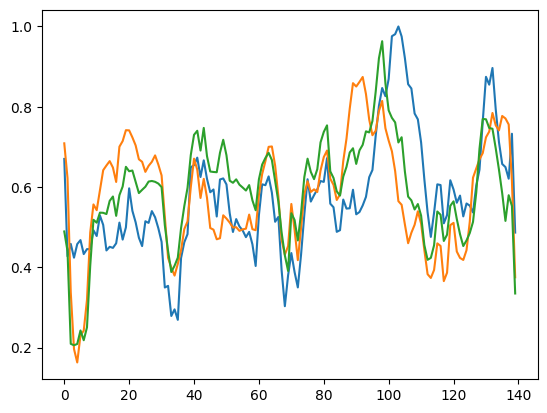

In [13]:
plt.plot(X_train[5])
plt.plot(X_train[25,:])
plt.plot(X_train[125,:])


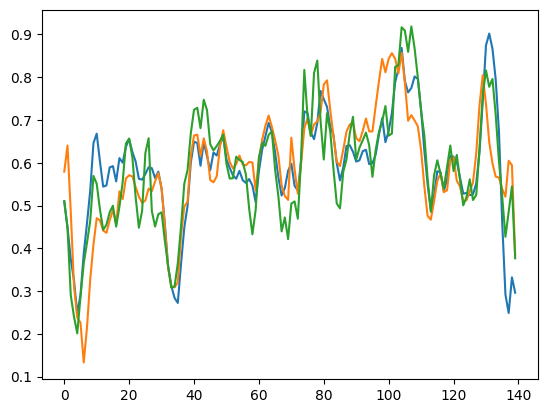

In [14]:
plt.plot(X_test[5])
plt.plot(X_test[25,:])
plt.plot(X_test[125,:])

In [15]:
X_train = tf.expand_dims(X_train, axis = -1)
X_test = tf.expand_dims(X_test, axis = -1)

In [16]:
img_generator = DataGenerator(img_shape = (10, 14), n_f = 1)
img_generator_output = img_generator(X_train)
fft_img_real, fft_img_imag, inputs_img = img_generator_output[:, :, :, 0], img_generator_output[:, :, :, 1], img_generator_output[:, :, :, 2]

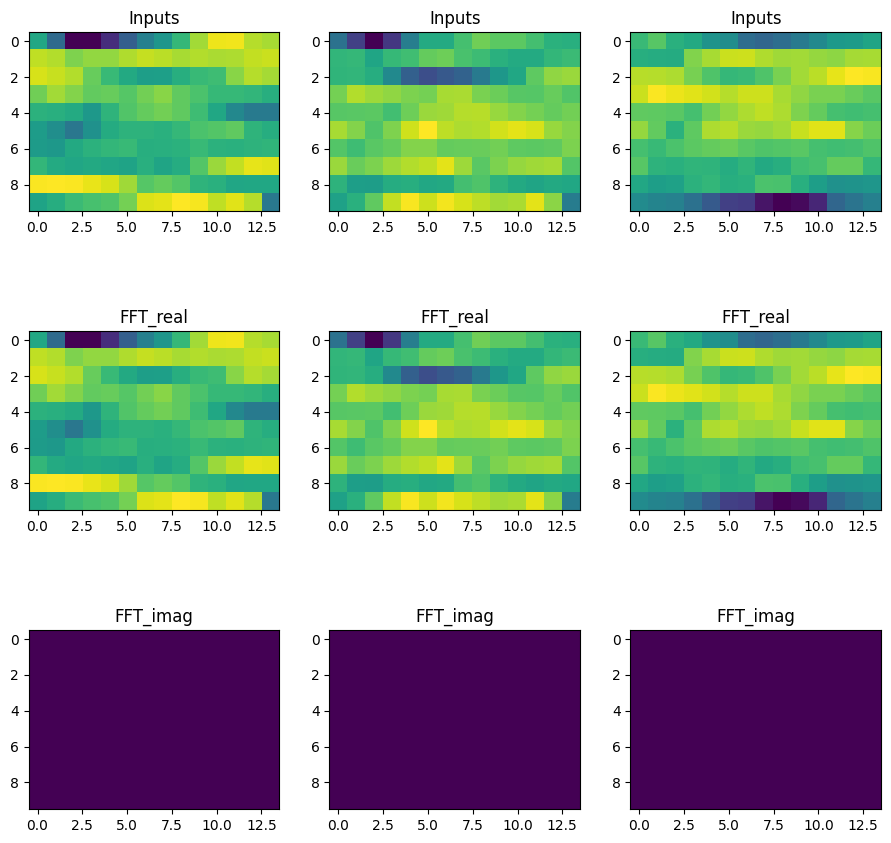

In [17]:
plt.figure(figsize = (11, 11))
for i in range(3):
  plt.subplot(3, 3, i+ 1)
  plt.imshow(inputs_img[i, :, :])
  plt.title("Inputs")
for i in range(4, 7):
  plt.subplot(3,3, i)
  plt.imshow(fft_img_real[i - 4, :, :])
  plt.title("FFT_real")
for i in range(7, 10):
  plt.subplot(3, 3, i)
  plt.imshow(fft_img_imag[i-7,:, :])
  plt.title("FFT_imag")



###Making Supervised Model and Training

In [18]:
ifd = IFD(transformed_img_shape = (10, 14), n_f = 1, T_x = 140, num_pred = 1, batch_size = 64, replace_part = True)

In [19]:
#Conv Model
inp = Input(shape = (10, 14, 3))
conv1 = Conv2D(32, (3,3), kernel_initializer = "he_normal")(inp)
conv1_norm = BatchNormalization()(conv1)
conv1_act = relu(conv1_norm)

conv2 = Conv2D(32, (3,3), kernel_initializer = "he_normal", padding = "same")(conv1_act)
conv2_norm = BatchNormalization()(conv2)
conv2_act = relu(conv2_norm)
conv2_act = Dropout(0.4)(conv2_act)
conv2_act = MaxPooling2D((2,2), strides = 2)(conv2_act)

conv3 = Conv2D(64, (3,3), kernel_initializer = "he_normal", padding = "same")(conv2_act)
conv3_norm = BatchNormalization()(conv3)
conv3_act = relu(conv3_norm)

conv4 = Conv2D(64, (3,3), kernel_initializer = "he_normal", padding = "same")(conv3_act)
conv4_norm = BatchNormalization()(conv4)
conv4_act = relu(conv4_norm)
conv4_act = Dropout(0.3)(conv4_act)

fnn_inp = Flatten(name = "Flatten")(conv4_act)
fnn1 = Dense(256, kernel_initializer = "he_normal")(fnn_inp)
fnn1_norm = BatchNormalization()(fnn1)
fnn1_act = Dropout(0.4)(relu(fnn1_norm))

fnn2 = Dense(128, kernel_initializer = "he_normal")(fnn1_act)
fnn2_norm = BatchNormalization()(fnn2)
fnn2_act = Dropout(0.4)(relu(fnn2_norm))

fnn3 = Dense(64, kernel_initializer = "he_normal")(fnn2_act)
fnn3_norm = BatchNormalization()(fnn3)
fnn3_act = Dropout(0.3)(relu(fnn3_norm))

fnn4 = Dense(20, kernel_initializer = "he_normal")(fnn3_act)
fnn4_norm = BatchNormalization()(fnn4)
fnn4_act = relu(fnn4_norm)

out = Dense(1, activation = "sigmoid")(fnn4_act)

conv_model = Model(inputs = [inp], outputs = [out])

In [20]:
ifd.set_conv_layer(conv_model)
ifd.set_Data_generator()

conv_layer is created
DataGenerator is created


In [21]:
model = ifd.create_model()

DataGenerator and Conv_layer is merged


In [22]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_1 (DataGenerator)     │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer (Conv_layer)              │ (None, 1)                   │         504,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 504,153 (1.92 MB)

 Trainable params: 502,833 (1.92 MB)

 Non-trainable params: 1,320 (5.16 KB)

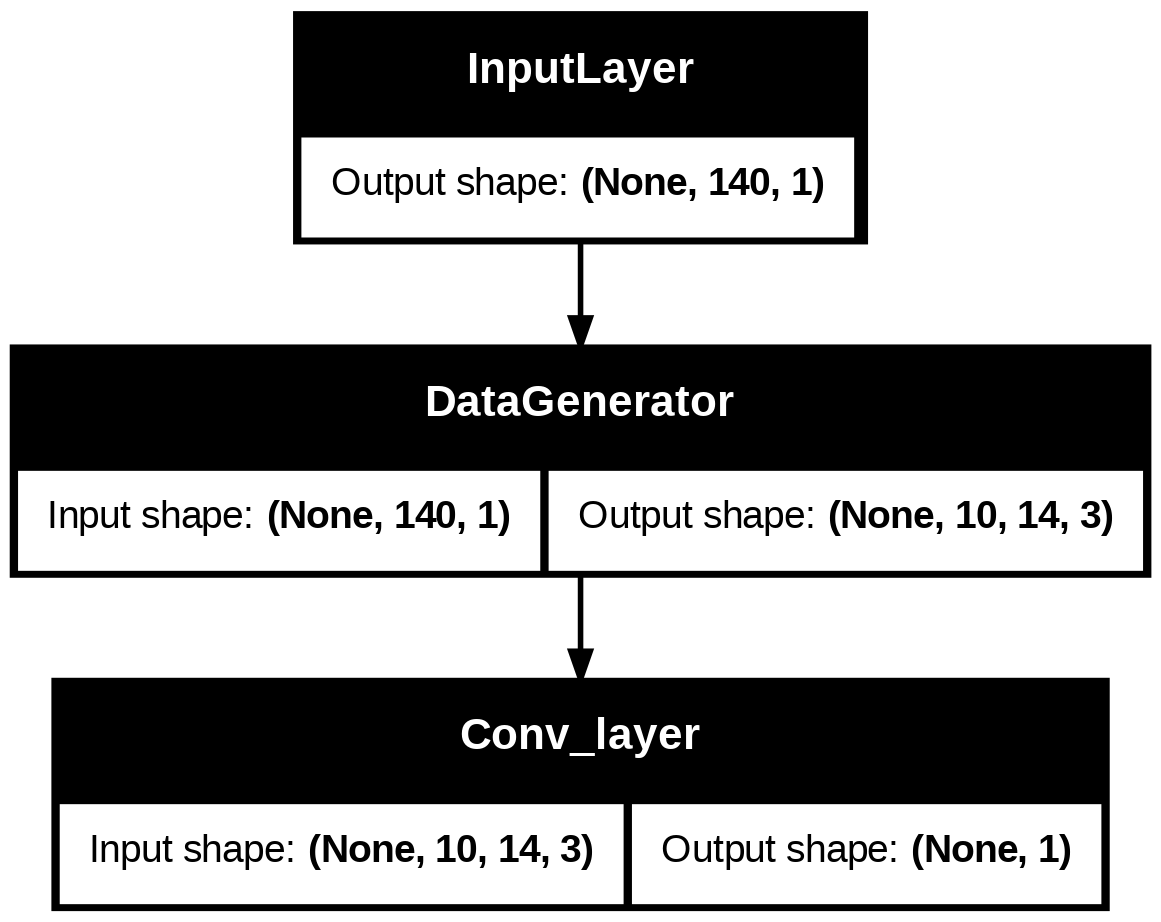

In [23]:
plot_model(model, show_shapes = True)

In [24]:
model.compile(optimizer = Adam(0.001), loss = "binary_crossentropy", metrics = ['f1_score'])

In [25]:
y_train = tf.expand_dims(y_train, axis = -1)
y_test = tf.expand_dims(y_test, axis = -1)

In [26]:
tf.math.reduce_sum(y_train)/len(y_train)

<tf.Tensor: shape=(), dtype=float64, numpy=0.5835417708854427>

In [27]:
tf.math.reduce_sum(y_test)/len(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=0.586>

In [28]:
his = model.fit(X_train, y_train, epochs = 10, batch_size = 64, validation_data = (X_test, y_test))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - f1_score: 0.7394 - loss: 0.3740 - val_f1_score: 0.7390 - val_loss: 0.1199
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - f1_score: 0.7384 - loss: 0.1084 - val_f1_score: 0.7390 - val_loss: 0.0695
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - f1_score: 0.7376 - loss: 0.0560 - val_f1_score: 0.7390 - val_loss: 0.0591
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - f1_score: 0.7284 - loss: 0.0498 - val_f1_score: 0.7390 - val_loss: 0.0512
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - f1_score: 0.7346 - loss: 0.0466 - val_f1_score: 0.7390 - val_loss: 0.0417
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - f1_score: 0.7373 - loss: 0.0288 - val_f1_score: 0.7390 - val_loss: 0.0551
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - f1_score: 0.7380 - loss: 0.0360 - val_f1_score: 0.7390 - val_loss: 0.0512
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - f1_score: 0.7348 - loss: 0.0253 - val_f1_score: 0.7390 

In [29]:
model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score: 0.7385 - loss: 0.0548


[0.06365220993757248, 0.7389659285545349]

In [30]:
cm = confusion_matrix(y_test, np.where(model.predict(X_test)> 0.5, 1, 0))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


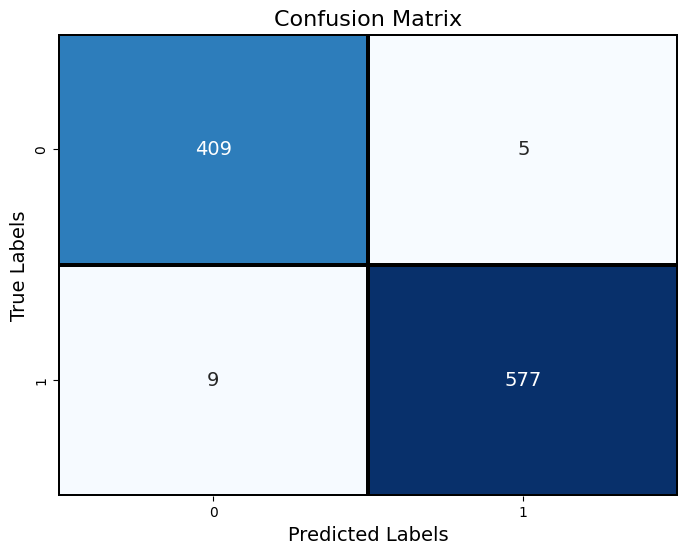

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


Text(70.72222222222221, 0.5, 'True Labels')

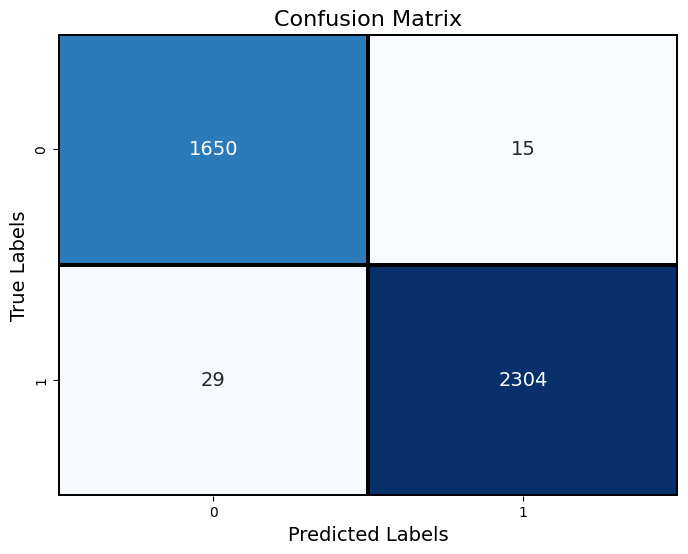

In [32]:
plt.figure(figsize = (8, 6))
cm = confusion_matrix(y_train, np.where(model.predict(X_train)>0.5, 1,0))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title("Confusion Matrix", fontsize = 16)
plt.xlabel("Predicted Labels", fontsize = 14)
plt.ylabel("True Labels", fontsize = 14)

###Using XGBoost

In [33]:
ConvXGB = ifd.create_and_train_ConvXGB(model, XGB(n_estimators = 300, min_depth = 5, verbosity = 3, booster = "gbtree", early_stopping_round = 20, eval_metrics = ["f1_score"]), X_train, y_train)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_2 (DataGenerator)     │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 1536)                │          66,336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,336 (259.12 KB)

 Trainable params: 65,952 (257.62 KB)

 Non-trainable params: 384 (1.50 KB)

[13:57:58] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[13:57:58] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:57:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_round", "eval_metrics", "min_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[13:57:58] ======== Monitor (0): HostSketchContainer ========
[13:57:58] AllReduce: 0.226054s, 1 calls @ 226054us

[13:57:58] MakeCuts: 0.23821s, 1 calls @ 238210us

[13:57:58] PushRowPage: 0.104821s, 1 calls @ 104821us

[13:58:13] ======== Monitor (0): Learner ========
[13:58:13] Configure: 0.003188s, 1 calls @ 3188us

[13:58:13] EvalOneIter: 0.004252s, 300 calls @ 4252us

[13:58:13] GetGradient: 0.232014s, 300 calls @ 232014us

[13:58:13] PredictRaw: 0.000976s, 300 calls @ 976us

[13:58:13] UpdateOneIter: 14.9842s, 300 calls @ 14984241us

[13:58:13] ======== Monitor (0): GBTree ========
[13:58:13] BoostNewTrees: 14.7446s, 300 calls @ 14744562us

[13:58:13] CommitModel: 0.000375s, 300 calls @ 375us

[13:58:13] ======== Monitor (0): HistUpdater ========
[13:58:13] BuildHistogram: 2.08162s, 180 calls @ 2081616us

[13:58:13] EvaluateSplits: 2.5197s, 480 calls @ 2519697us

[13:58:13] InitData: 0.960094s, 300 calls @ 960094us

[13:58:13] InitRoot: 9.7772s, 300 calls @ 9777195us

[13:58:13]

In [34]:
flatten_img = tf.reshape(ConvXGB.pre_xgb_model(X_test)[0][:9, :], shape = (9, 48, 32))

In [35]:
output = ConvXGB.pre_xgb_model(X_test)

In [36]:
output[0]

<tf.Tensor: shape=(1000, 1536), dtype=float32, numpy=
array([[0.92513657, 0.3556962 , 0.        , ..., 1.1426275 , 0.        ,
        0.        ],
       [1.3236259 , 0.        , 0.        , ..., 1.3359163 , 1.0468445 ,
        0.        ],
       [1.3631345 , 0.06480727, 0.        , ..., 1.0886712 , 1.5385062 ,
        0.        ],
       ...,
       [0.5007187 , 0.        , 0.01387262, ..., 0.3545367 , 0.        ,
        0.        ],
       [1.1295366 , 0.        , 0.26778793, ..., 0.9710827 , 0.1015044 ,
        0.        ],
       [0.46810582, 0.        , 0.        , ..., 0.4381439 , 0.        ,
        0.        ]], dtype=float32)>

In [37]:
pred = ConvXGB.XGB_model.predict(output[0])
cm = confusion_matrix(y_test, pred)

[13:58:14] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0


In [38]:
print(f"f1_score(Convxgb):{f1_score(y_test, pred)}")
# print(f"f1_score(model): {f1_score(y_test, np.where(model.predict(X_test) >= 0.5, 1, 0))}")

f1_score(Convxgb):0.9923534409515717


In [39]:
print(f"f1_score(model): {f1_score(y_test, np.where(model.predict(X_test) >= 0.5, 1, 0))}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
f1_score(model): 0.9897435897435898


In [40]:
X_test

<tf.Tensor: shape=(1000, 140, 1), dtype=float64, numpy=
array([[[0.47735054],
        [0.64257435],
        [0.41470145],
        ...,
        [0.6719969 ],
        [0.72039023],
        [0.3925729 ]],

       [[0.52593269],
        [0.40183041],
        [0.19358493],
        ...,
        [0.64656913],
        [0.67436641],
        [0.40679355]],

       [[0.70635211],
        [0.75784175],
        [0.59569236],
        ...,
        [0.7859432 ],
        [0.75008355],
        [0.59482503]],

       ...,

       [[0.61299602],
        [0.66498255],
        [0.58336473],
        ...,
        [0.17276074],
        [0.17592232],
        [0.29589593]],

       [[0.64297051],
        [0.50995932],
        [0.28044978],
        ...,
        [0.65431204],
        [0.59160528],
        [0.28309901]],

       [[0.64023798],
        [0.64144649],
        [0.50807695],
        ...,
        [0.20714112],
        [0.26828633],
        [0.34933348]]])>

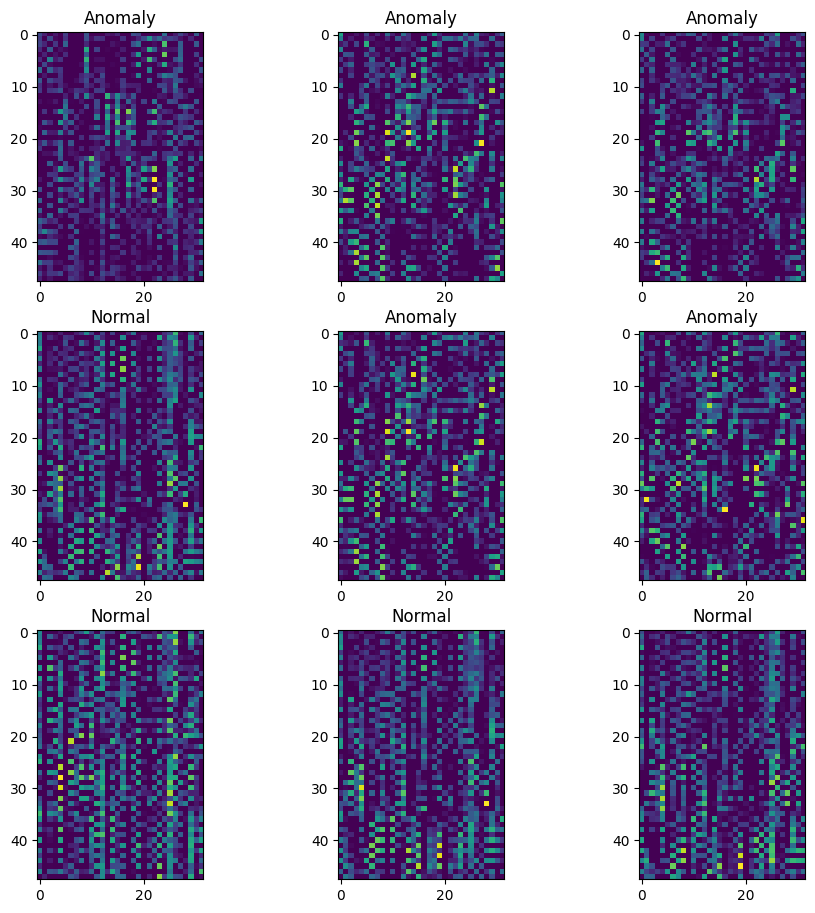

In [41]:
plt.figure(figsize = (11, 11))
for i in range(9):
  plt.subplot(3, 3, i+ 1)
  plt.imshow(flatten_img[i, :, :])
  plt.title(f"Anomaly" if y_test[i] else "Normal")

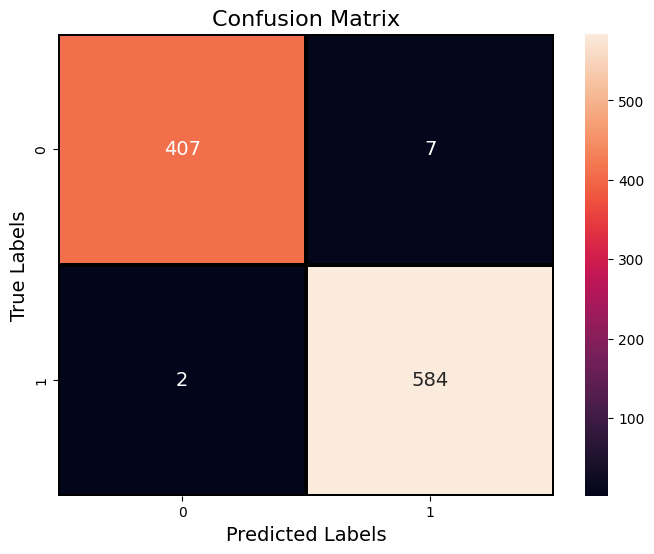

In [42]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cbar = True,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

###Using Isolation Forest

In [43]:
#Making ConvISO for Unsupervised learning model
iso_forest = IsolationForest(n_estimators = 300, random_state = 42, contamination = 0.5)
ConvISO = ifd.create_and_train_ConvISO(model, iso_forest, X_train)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_3 (DataGenerator)     │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 1536)                │          66,336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,336 (259.12 KB)

 Trainable params: 65,952 (257.62 KB)

 Non-trainable params: 384 (1.50 KB)

In [44]:
iso_output = ConvISO.pre_iso_model(X_test)

In [45]:
iso_output[0]

<tf.Tensor: shape=(1000, 1536), dtype=float32, numpy=
array([[0.9266032 , 0.32906762, 0.        , ..., 1.1393162 , 0.        ,
        0.        ],
       [1.3255569 , 0.        , 0.        , ..., 1.3236675 , 1.0401298 ,
        0.        ],
       [1.3636425 , 0.03837374, 0.        , ..., 1.0785207 , 1.529668  ,
        0.        ],
       ...,
       [0.50355035, 0.        , 0.01747921, ..., 0.34734935, 0.        ,
        0.        ],
       [1.1299309 , 0.        , 0.26419657, ..., 0.96765554, 0.094062  ,
        0.        ],
       [0.4695401 , 0.        , 0.        , ..., 0.43244267, 0.        ,
        0.        ]], dtype=float32)>

Isolation isn't performing better because of high contamination in dataset and anomalies are also making a cluster

In [46]:
f1_score(np.where(ConvISO.ISO_model.predict(iso_output[0]) == -1, 1, 0), y_test)

0.4532839962997225

In [47]:
np.where(ConvISO.ISO_model.predict(iso_output[0]) == -1, 1, 0)

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,

In [48]:
reducer = UMAP(random_state = 42)
X_reduced = reducer.fit_transform(tf.squeeze(X_train))

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [49]:
X_reduced

array([[ 9.968453 ,  5.2922297],
       [14.072041 ,  9.13331  ],
       [-1.2878761, 11.141963 ],
       ...,
       [-3.9800026,  9.439536 ],
       [15.439545 ,  2.798414 ],
       [11.746734 , 10.638031 ]], dtype=float32)

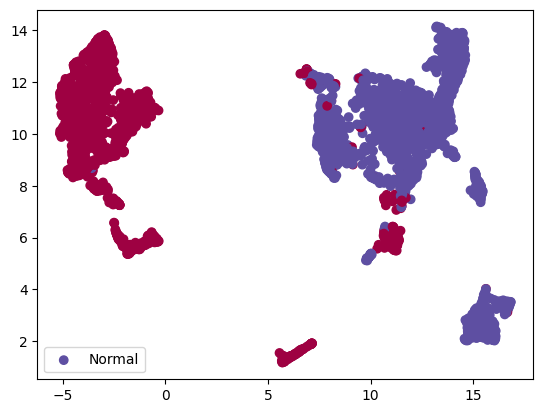

In [50]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = y_train, cmap = "Spectral")
plt.legend(["Normal", "Anomaly"])

In [51]:
#lets create  dataset for f1_score with contamination 0.1 or other
X_anomalies_pre = tf.gather(X_train, tf.where(y_train == 1)[:, 0])
X_anomalies_pre = tf.random.shuffle(X_anomalies_pre)
X_anomalies = X_anomalies_pre[:int(0.15*len(X_anomalies_pre))]
X_normal = tf.gather(X_train, tf.where(y_train == 0)[:, 0])
X_normal = tf.random.shuffle(X_normal)
X_train_iso = tf.concat([X_anomalies, X_normal], axis = 0)
X_train_iso = tf.random.shuffle(X_train_iso)
contamination =  len(X_anomalies)/len(X_train_iso)
contamination

0.17328699106256207

<ipython-input-52-38618768132a>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_iso_red[:, 0], X_train_iso_red[:, 1], cmap = "Spectral")


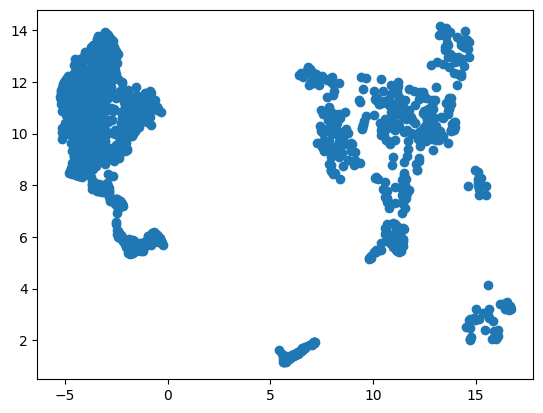

In [52]:
iso_forest = IsolationForest(n_estimators = 350, random_state = 42, contamination = contamination)
X_train_iso_red = reducer.transform(tf.squeeze(X_train_iso))
plt.scatter(X_train_iso_red[:, 0], X_train_iso_red[:, 1], cmap = "Spectral")

In [53]:
Conviso2 = ifd.create_and_train_ConvISO(model, iso_forest, X_train_iso)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_4 (DataGenerator)     │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 1536)                │          66,336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,336 (259.12 KB)

 Trainable params: 65,952 (257.62 KB)

 Non-trainable params: 384 (1.50 KB)

In [54]:
iso_output_2 = Conviso2.pre_iso_model(X_test)
iso_pred_2 = Conviso2.ISO_model.predict(iso_output_2[0])

In [55]:
cm = confusion_matrix(y_test, np.where(iso_pred_2 == -1, 1, 0))
f1_score(y_test, np.where(iso_pred_2 == -1, 1, 0))

0.6702241195304163

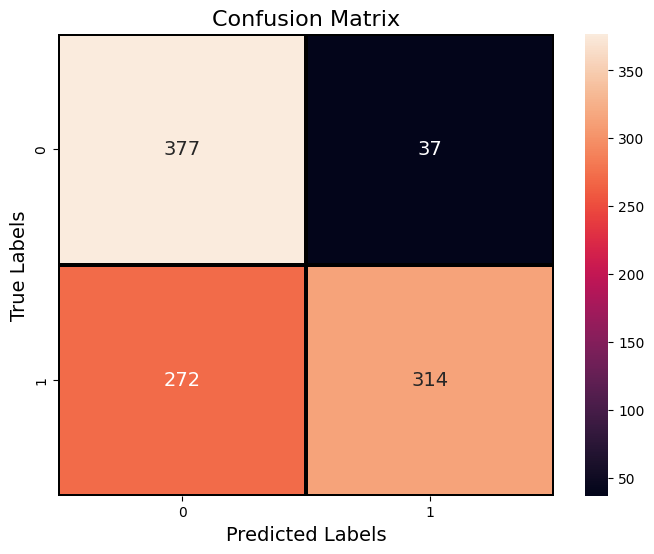

In [56]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cbar = True,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

<ipython-input-57-bf320b76f144>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_anomalies_sep_red[:, 0], X_anomalies_sep_red[:, 1], cmap = "Spectral")


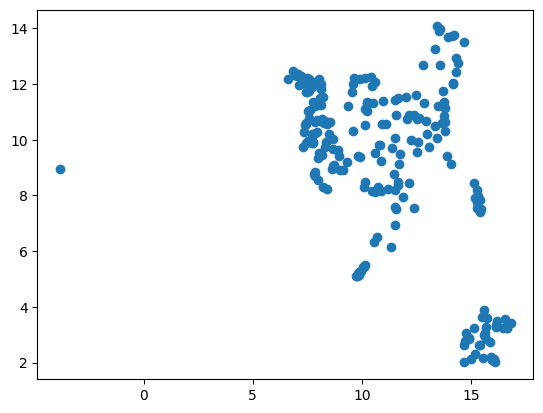

In [57]:
#lets create more effective dataset for  isolation forest using kmeans_plusplus to get farthest point in dataset
X_anomalies_sep, _ = kmeans_plusplus(np.array(tf.squeeze(X_anomalies_pre)), n_clusters = int(0.1*len(X_anomalies_pre)))
X_anomalies_sep = tf.convert_to_tensor(X_anomalies_sep)
X_anomalies_sep = tf.expand_dims(X_anomalies_sep, axis = -1)
X_anomalies_sep_red = reducer.transform(tf.squeeze(X_anomalies_sep))
plt.scatter(X_anomalies_sep_red[:, 0], X_anomalies_sep_red[:, 1], cmap = "Spectral")

In [58]:
#lets create dataset with normal points too!!
X_train_iso_2 = tf.concat([X_anomalies_sep, X_normal], axis = 0)
X_train_iso_2 = tf.random.shuffle(X_train_iso_2)
contamination2 =  len(X_anomalies_sep)/len(X_train_iso_2)
contamination2

0.12276080084299262

<ipython-input-59-ecd71b0b0613>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_normal_red[:, 0], X_normal_red[:, 1], cmap = "Spectral")


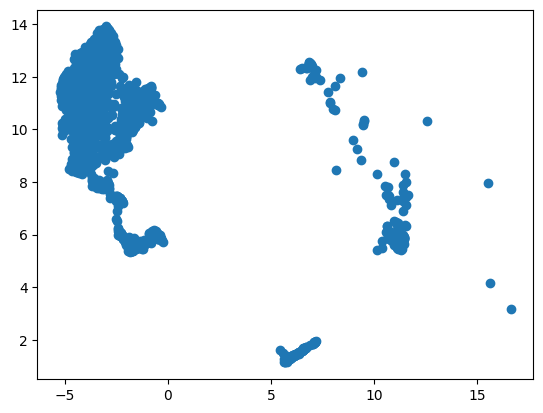

In [59]:
X_normal_red = reducer.transform(tf.squeeze(X_normal))
plt.scatter(X_normal_red[:, 0], X_normal_red[:, 1], cmap = "Spectral")

<ipython-input-60-b327f1461c22>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_iso_2_red[:, 0], X_train_iso_2_red[:, 1], cmap = "Spectral")


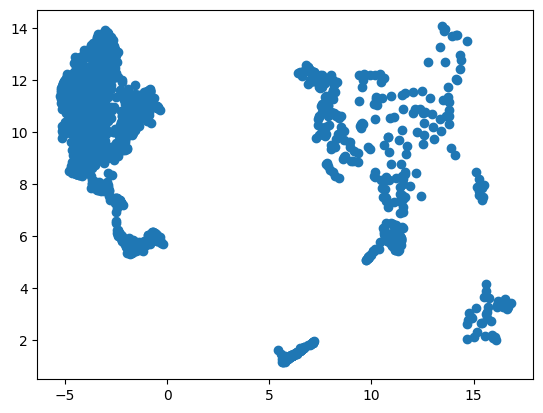

In [60]:
X_train_iso_2_red = reducer.transform(tf.squeeze(X_train_iso_2))
plt.scatter(X_train_iso_2_red[:, 0], X_train_iso_2_red[:, 1], cmap = "Spectral")

In [61]:
iso_forest = IsolationForest(n_estimators = 350, random_state = 42, contamination = 0.2)
Conviso3 = ifd.create_and_train_ConvISO(model, iso_forest, X_train_iso_2)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_5 (DataGenerator)     │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 1536)                │          66,336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,336 (259.12 KB)

 Trainable params: 65,952 (257.62 KB)

 Non-trainable params: 384 (1.50 KB)

In [62]:
iso_output_3 = Conviso3.pre_iso_model(X_test)
iso_pred_3 = Conviso3.ISO_model.predict(iso_output_3[0])

In [63]:
cm = confusion_matrix(y_test, np.where(iso_pred_3 == -1, 1, 0))
f1_score(y_test, np.where(iso_pred_3 == -1, 1, 0))

0.9627174813587407

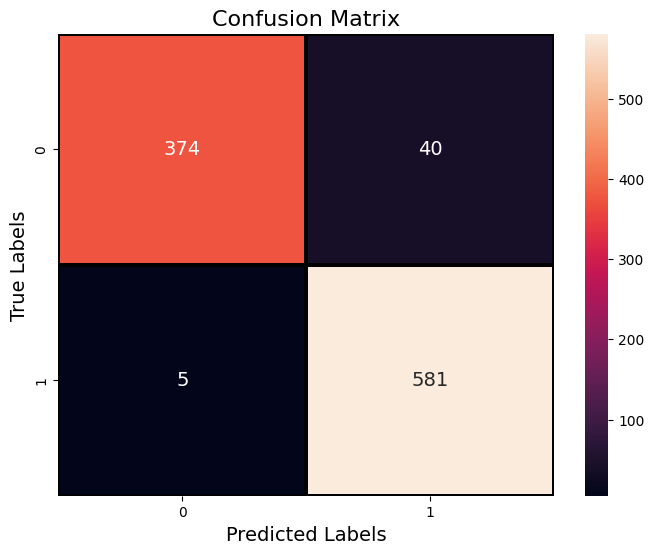

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cbar = True,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

###Using  SVM

In [65]:
X_train_svm = tf.gather(X_train, tf.where(y_train == 0)[:, 0])

In [66]:
X_train_svm

<tf.Tensor: shape=(1665, 140, 1), dtype=float64, numpy=
array([[[0.5897463 ],
        [0.63495192],
        [0.56035766],
        ...,
        [0.3379652 ],
        [0.37896403],
        [0.41542167]],

       [[0.47751352],
        [0.45991535],
        [0.30873102],
        ...,
        [0.62554027],
        [0.58558589],
        [0.51376626]],

       [[0.55535031],
        [0.51177331],
        [0.31398601],
        ...,
        [0.29011523],
        [0.42274018],
        [0.40795457]],

       ...,

       [[0.63284443],
        [0.68330828],
        [0.62672118],
        ...,
        [0.53924695],
        [0.48592347],
        [0.4469049 ]],

       [[0.5932317 ],
        [0.59425296],
        [0.45065838],
        ...,
        [0.48486439],
        [0.56162615],
        [0.5219022 ]],

       [[0.52444916],
        [0.48341841],
        [0.28728345],
        ...,
        [0.25656118],
        [0.36899361],
        [0.34701134]]])>

In [67]:
svm = ocsvm(degree = 4, gamma = 0.01, nu = 0.01, kernel = "poly", verbose = True)
ConvSVM = ifd.create_and_train_ConvSVM(model, svm, X_train_svm)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_6 (DataGenerator)     │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 1536)                │          66,336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,336 (259.12 KB)

 Trainable params: 65,952 (257.62 KB)

 Non-trainable params: 384 (1.50 KB)

[LibSVM]

In [68]:
svm_output = ConvSVM.pre_svm_model(X_test)
pred_svm = ConvSVM.SVM_model.predict(svm_output[0])
pred_svm = np.where(pred_svm == -1, 1, 0)

###Making Unsupervised Model and Training

In [69]:
ifd = IFD(transformed_img_shape = (10, 14), n_f = 1, T_x = 140, num_pred = 0, batch_size = 64, replace_part = True)

In [70]:
#AutoEncoder model
inp = Input(shape = (10, 14, 3), name = "input") #(10, 14)
conv1 = Conv2D(40, (3,3), kernel_initializer = "he_normal", padding = "same")(inp)
conv1_norm = BatchNormalization()(conv1)
conv1_act = relu(conv1_norm)
conv1_act = Dropout(0.3)(conv1_act)

conv2 = Conv2D(30, (3,3), kernel_initializer = "he_normal")(conv1_act)#(8, 12)
conv2_norm = BatchNormalization()(conv2)
conv2_act = relu(conv2_norm)
conv2_act = Dropout(0.3)(conv2_act)

conv3 = Conv2D(15, (3,3), kernel_initializer = "he_normal")(conv2_act)#(6, 10)
conv3_norm = BatchNormalization()(conv3)
conv3_act = relu(conv3_norm)

conv3_act = MaxPooling2D((2, 2), strides = 2, name = "Middle")(conv3_act) #(3, 5)

# Decoder Model (Mirror of Encoder)
deconv1 = Conv2DTranspose(15, (2, 2), strides =2, kernel_initializer="he_normal")(conv3_act)  #(6, 10)
deconv1_norm = BatchNormalization()(deconv1)
deconv1_act = relu(deconv1_norm)

deconv2 = Conv2DTranspose(30, (3, 3), kernel_initializer="he_normal")(deconv1_act)  # (8, 12)
deconv2_norm = BatchNormalization()(deconv2)
deconv2_act = relu(deconv2_norm)
deconv2_act = Dropout(0.3)(deconv2_act)

deconv3 = Conv2DTranspose(40, (3, 3), kernel_initializer="he_normal")(deconv2_act)  # (10, 14)
deconv3_norm = BatchNormalization()(deconv3)
deconv3_act = relu(deconv3_norm)
deconv3_act = Dropout(0.3)(deconv3_act)

# Final Output Layer
output = Conv2DTranspose(3, (3, 3), activation='sigmoid', name="output", padding = "same")(deconv3_act)  # (10, 14, 3)

auto_encoder = Model(inputs = [inp], outputs = [output])



In [71]:
ifd.set_conv_layer(auto_encoder, auto_encoder = True)
ifd.set_Data_generator()

conv_layer is created
DataGenerator is created


In [72]:
model = ifd.create_model()

DataGenerator and Conv_layer is merged


In [73]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_7 (DataGenerator)     │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_1 (Conv_layer)            │ (None, 10, 14, 3)           │          33,613 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_reverser (DataReverser)         │ (None, 140, 1)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,613 (131.30 KB)

 Trainable params: 33,273 (129.97 KB)

 Non-trainable params: 340 (1.33 KB)

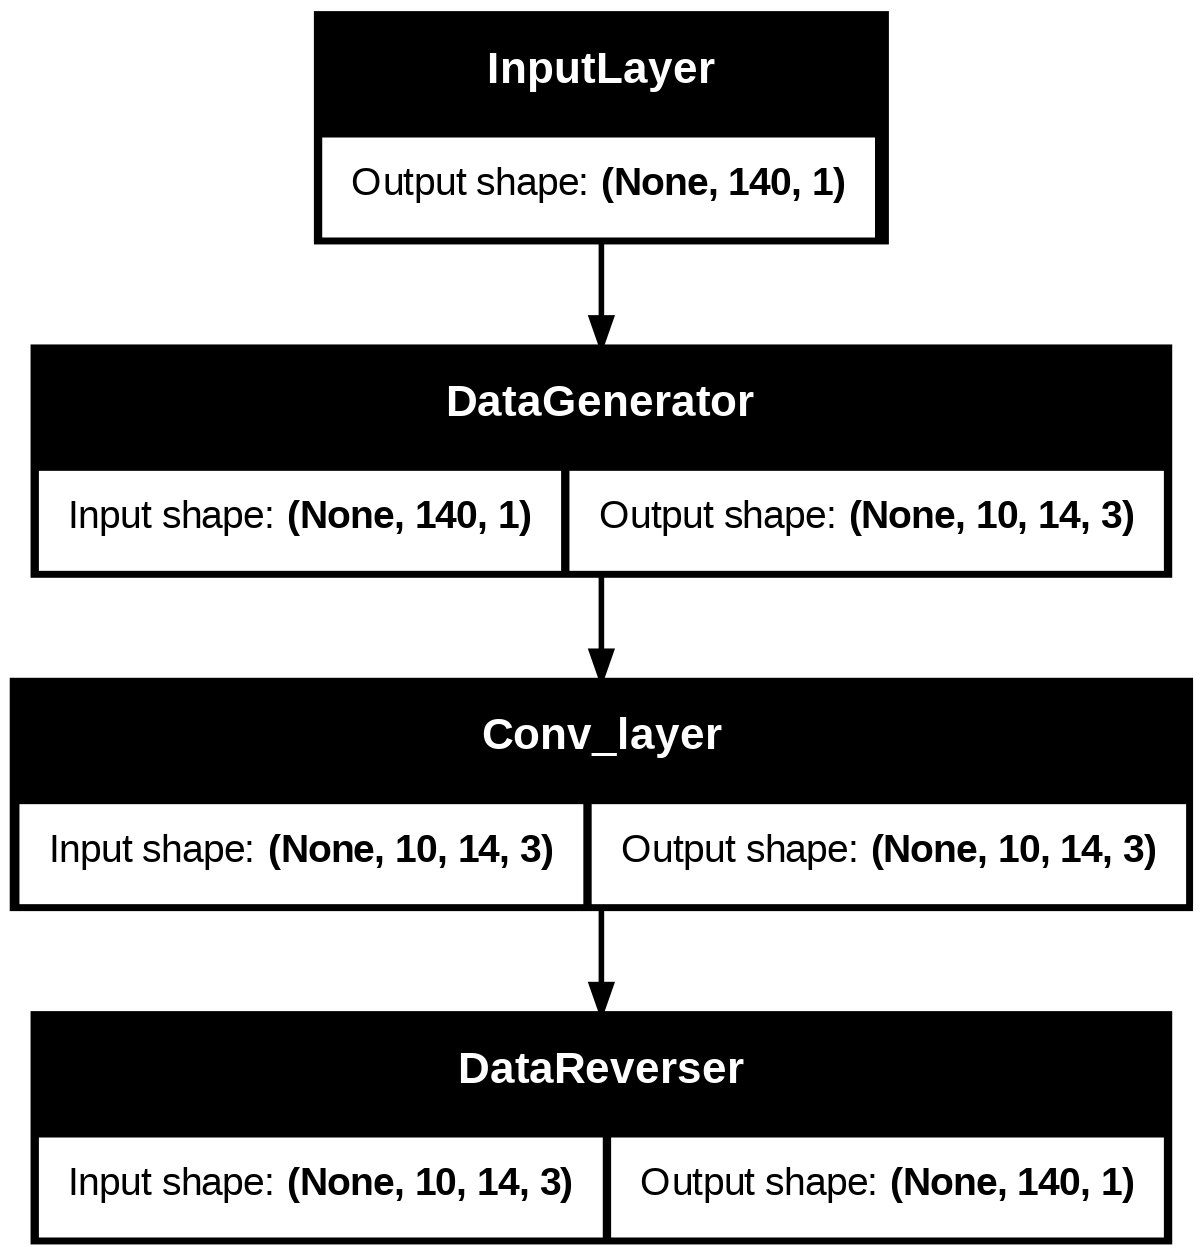

In [74]:
plot_model(model, show_shapes = True)

In [75]:
model.compile(optimizer = Adam(0.001), loss = "mse")

In [76]:
X_train_auto = tf.gather(X_train, tf.where(y_train == 0)[:, 0])
X_test_auto = tf.gather(X_test, tf.where(y_test == 0)[:, 0])

In [77]:
X_train_auto_copy = tf.identity(X_train_auto)
X_test_auto_copy = tf.identity(X_test_auto)
tf.shape(X_train_auto) == tf.shape(X_train_auto_copy)

<tf.Tensor: shape=(3,), dtype=bool, numpy=array([ True,  True,  True])>

In [78]:
his = model.fit(X_train_auto, X_train_auto_copy, epochs = 20, batch_size = 64, validation_data = (X_test_auto, X_test_auto_copy))

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - loss: 0.0352 - val_loss: 0.0178
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 0.0153 - val_loss: 0.0106
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 0.0074 - val_loss: 0.0065
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - l

In [79]:
X_test_auto_abnorm = tf.gather(X_test, tf.where(y_test == 1)[:, 0])
model.evaluate(X_test_auto_abnorm, tf.identity(X_test_auto_abnorm))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0136


0.013631859794259071

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


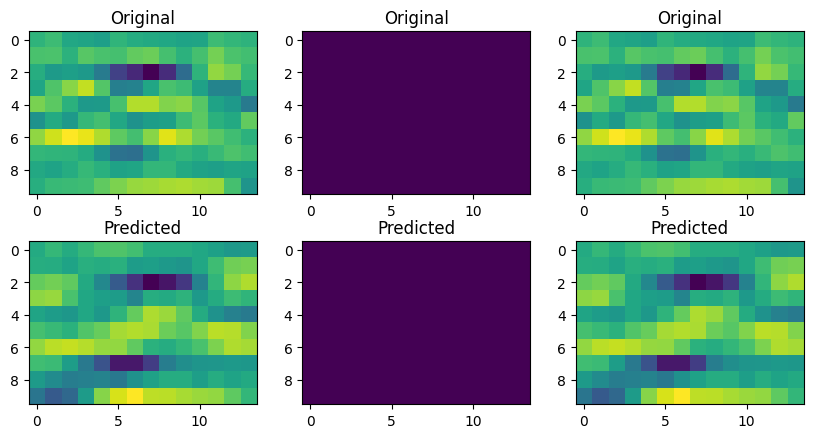

In [80]:
X_test_auto_pred = model.predict(X_test_auto)
generator = DataGenerator(img_shape = (10, 14), n_f = 1)

img_generator_output_pred = generator(X_test_auto_pred)
img_generator_output = generator(X_test_auto)

plt.figure(figsize = (10, 5))
for i in range(0, 3):
  plt.subplot(2, 3, i + 1)
  plt.imshow(img_generator_output[5, :, :, i])
  plt.title("Original")
  plt.subplot(2, 3, i + 4)
  plt.imshow(img_generator_output_pred[5, :, :, i ])
  plt.title("Predicted")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


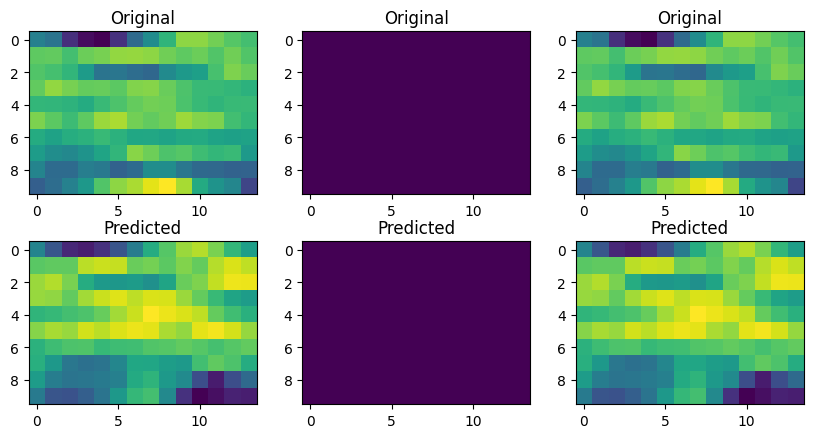

In [81]:
X_test_auto_pred = model.predict(X_test_auto_abnorm)
generator = DataGenerator(img_shape = (10, 14), n_f = 1)

img_generator_output_pred = generator(X_test_auto_pred)
img_generator_output = generator(X_test_auto_abnorm)

plt.figure(figsize = (10, 5))
for i in range(0, 3):
  plt.subplot(2, 3, i + 1)
  plt.imshow(img_generator_output[6, :, :, i])
  plt.title("Original")
  plt.subplot(2, 3, i + 4)
  plt.imshow(img_generator_output_pred[6, :, :, i ])
  plt.title("Predicted")



In [82]:
threshold_list = np.arange(0.0008, 0.015, 0.001)
f1_score_list = []
for threshold in threshold_list:
  y_pred = tf.reduce_sum(tf.square(tf.subtract(X_train, model.predict(X_train))), axis = 1)/140
  y_pred = np.where(y_pred >= threshold , 1, 0)
  f1_score_list.append(f1_score(y_train, y_pred))

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


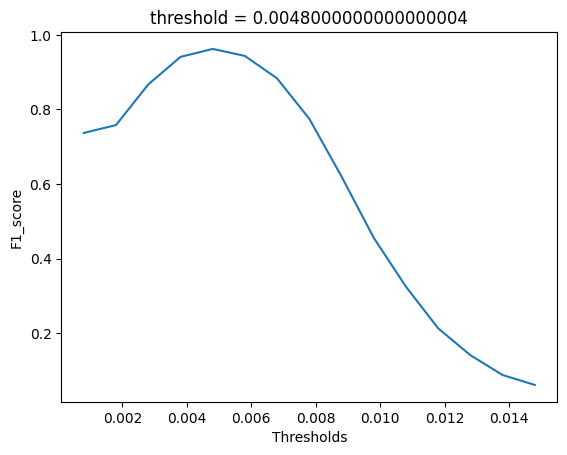

In [83]:
plt.plot(threshold_list, f1_score_list)
plt.ylabel("F1_score")
plt.xlabel("Thresholds")
plt.title("Thresold vs F1_score")
plt.title(f"threshold = {threshold_list[np.argmax(f1_score_list)]}")
plt.show()

In [84]:
threshold_auto = threshold_list[np.argmax(f1_score_list)]
y_pred = tf.reduce_sum(tf.square(tf.subtract(X_train, model.predict(X_train))), axis = 1)/140
y_pred = np.where(y_pred >= threshold_auto , 1, 0)
print(f1_score(y_train, y_pred))
cm = confusion_matrix(y_train, y_pred)

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
0.960183447988326


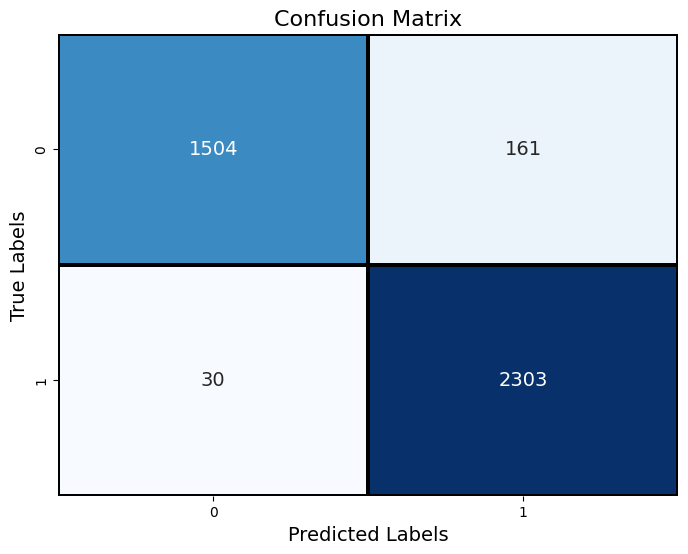

In [85]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

###Using XGBoost for Unsupervised Model

In [86]:
ConvXGB_auto = ifd.create_and_train_ConvXGB(model, XGB(n_estimators = 300, min_depth = 5, verbosity = 3, booster = "gbtree", early_stopping_round = 20, eval_metrics = ["f1_score"]), X_train, y_train)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_10 (DataGenerator)    │ (None, 10, 14, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_9 (Functional)            │ (None, 3, 5, 15)            │          16,355 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 225)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,355 (63.89 KB)

 Trainable params: 16,185 (63.22 KB)

 Non-trainable params: 170 (680.00 B)

[14:02:47] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[14:02:47] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[14:02:47] ======== Monitor (0): HostSketchContainer ========
[14:02:47] AllReduce: 0.045354s, 1 calls @ 45354us

[14:02:47] MakeCuts: 0.047029s, 1 calls @ 47029us

[14:02:47] PushRowPage: 0.011899s, 1 calls @ 11899us



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:02:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_round", "eval_metrics", "min_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[14:02:50] ======== Monitor (0): Learner ========
[14:02:50] Configure: 0.002264s, 1 calls @ 2264us

[14:02:50] EvalOneIter: 0.00317s, 300 calls @ 3170us

[14:02:50] GetGradient: 0.045065s, 300 calls @ 45065us

[14:02:50] PredictRaw: 0.001003s, 300 calls @ 1003us

[14:02:50] UpdateOneIter: 2.55665s, 300 calls @ 2556647us

[14:02:50] ======== Monitor (0): GBTree ========
[14:02:50] BoostNewTrees: 2.50558s, 300 calls @ 2505580us

[14:02:50] CommitModel: 0.000288s, 300 calls @ 288us

[14:02:50] ======== Monitor (0): HistUpdater ========
[14:02:50] BuildHistogram: 0.654003s, 498 calls @ 654003us

[14:02:50] EvaluateSplits: 1.01233s, 798 calls @ 1012332us

[14:02:50] InitData: 0.120265s, 300 calls @ 120265us

[14:02:50] InitRoot: 0.948477s, 300 calls @ 948477us

[14:02:50] LeafPartition: 8.3e-05s, 300 calls @ 83us

[14:02:50] UpdatePosition: 0.046442s, 512 calls @ 46442us

[14:02:50] UpdatePredictionCache: 0.014805s, 300 calls @ 14805us

[14:02:50] UpdateTree: 2.48522s, 300 calls @ 2485225u

In [87]:
#Lets see the how pre_xgb model output looks like
pre_convxgb_auto_pred_image = tf.reshape(ConvXGB_auto.pre_xgb_model(X_train), shape = (-1, 15,15))

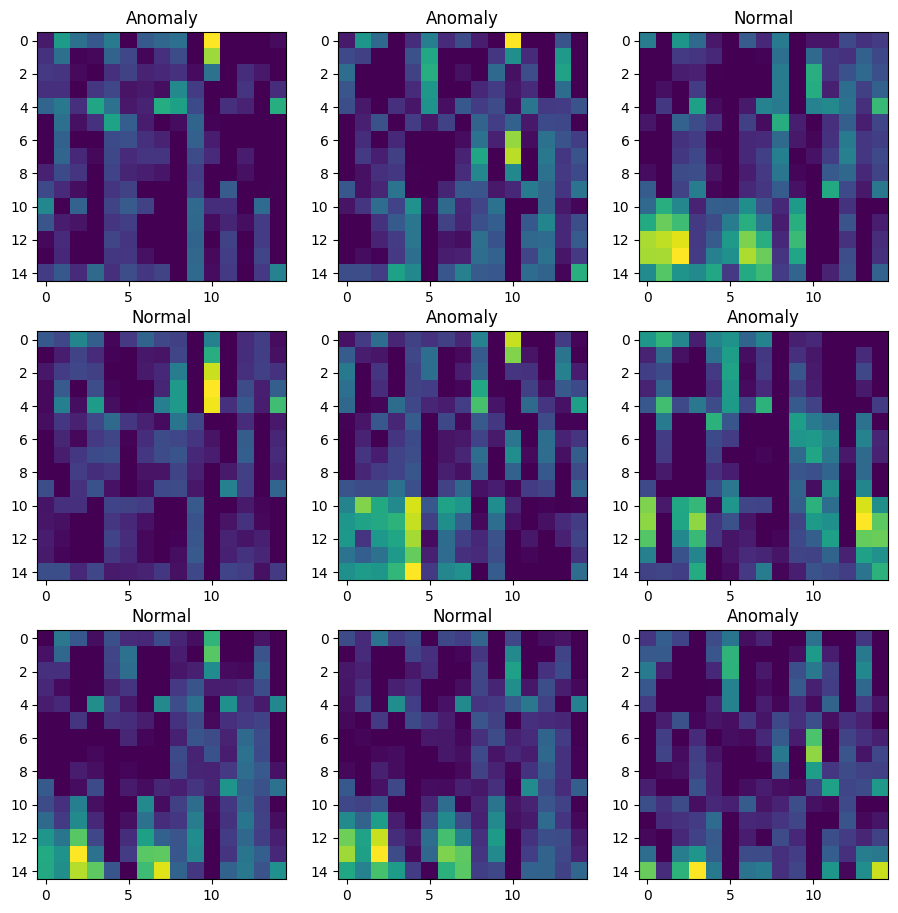

In [88]:
plt.figure(figsize = (11, 11))
for i in range(9):
  plt.subplot(3, 3, i+ 1)
  plt.imshow(pre_convxgb_auto_pred_image[i, :, :])
  plt.title(f"Anomaly" if y_train[i] else "Normal")

In [89]:
pre_convxgb_auto_pred = ConvXGB_auto.pre_xgb_model.predict(X_train)
convxgb_auto_pred = ConvXGB_auto.XGB_model.predict(pre_convxgb_auto_pred)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[14:02:55] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0


In [90]:
print(f1_score(y_train, convxgb_auto_pred))
cm = confusion_matrix(y_train, convxgb_auto_pred)

1.0


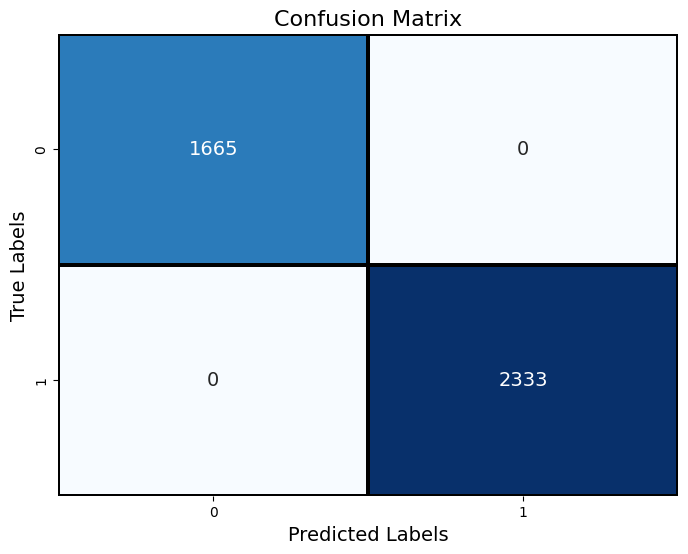

In [91]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

In [92]:
pre_convxgb_auto_pred = ConvXGB_auto.pre_xgb_model.predict(X_test)
convxgb_auto_pred = ConvXGB_auto.XGB_model.predict(pre_convxgb_auto_pred)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [93]:
print(f1_score(y_test, convxgb_auto_pred))
cm = confusion_matrix(y_test, convxgb_auto_pred)

0.9931856899488927


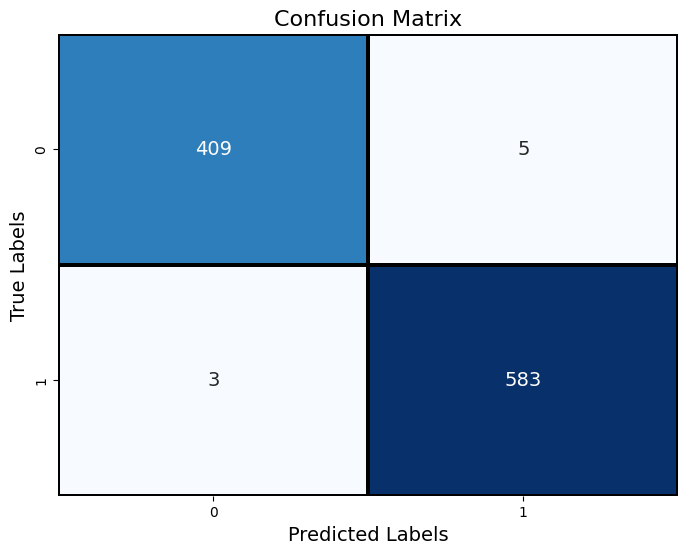

In [94]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

###Using Isolation forest for Unsupervised Model

In [95]:
#Making ConvISO for Unsupervised learning model
iso_forest = IsolationForest(n_estimators = 300, random_state = 42, contamination = 0.5)
ConvISO = ifd.create_and_train_ConvISO(model, iso_forest, X_train)

In [96]:
iso_output = ConvISO.pre_iso_model(X_train)

In [97]:
iso_output

<tf.Tensor: shape=(3998, 225), dtype=float32, numpy=
array([[0.3254418 , 2.3901334 , 1.6174685 , ..., 0.        , 0.7318788 ,
        1.9377362 ],
       [0.2349675 , 1.6828022 , 1.0966241 , ..., 1.0113901 , 0.039941  ,
        2.0088434 ],
       [1.704049  , 0.        , 2.141983  , ..., 0.9995228 , 0.        ,
        1.2722807 ],
       ...,
       [0.06616843, 1.1300524 , 1.256655  , ..., 1.2855116 , 0.774966  ,
        1.2888001 ],
       [0.9057277 , 1.635393  , 1.1310493 , ..., 0.30219287, 1.8179576 ,
        3.8471456 ],
       [0.29434448, 1.7224947 , 1.1884872 , ..., 1.0791184 , 0.31076205,
        2.2383423 ]], dtype=float32)>

Isolation isn't performing better because of high contamination in dataset and anomalies are also making a cluster

In [98]:
f1_score(np.where(ConvISO.ISO_model.predict(iso_output) == -1, 1, 0), y_train)

0.40350877192982454

In [99]:
reducer = UMAP(random_state = 42)
X_reduced = reducer.fit_transform(tf.squeeze(X_train))

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [100]:
X_reduced

array([[ 9.968453 ,  5.2922297],
       [14.072041 ,  9.13331  ],
       [-1.2878761, 11.141963 ],
       ...,
       [-3.9800026,  9.439536 ],
       [15.439545 ,  2.798414 ],
       [11.746734 , 10.638031 ]], dtype=float32)

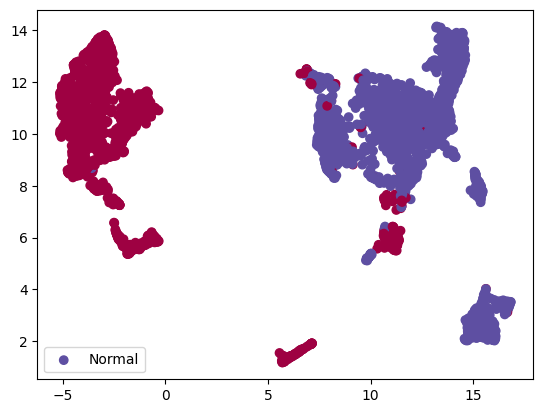

In [101]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = y_train, cmap = "Spectral")
plt.legend(["Normal", "Anomaly"])

In [102]:
#lets create  dataset for f1_score with contamination 0.1 or other
X_anomalies_pre = tf.gather(X_train, tf.where(y_train == 1)[:, 0])
X_anomalies_pre = tf.random.shuffle(X_anomalies_pre)
X_anomalies = X_anomalies_pre[:int(0.15*len(X_anomalies_pre))]
X_normal = tf.gather(X_train, tf.where(y_train == 0)[:, 0])
X_normal = tf.random.shuffle(X_normal)
X_train_iso = tf.concat([X_anomalies, X_normal], axis = 0)
X_train_iso = tf.random.shuffle(X_train_iso)
contamination =  len(X_anomalies)/len(X_train_iso)
contamination

0.17328699106256207

<ipython-input-103-38618768132a>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_iso_red[:, 0], X_train_iso_red[:, 1], cmap = "Spectral")


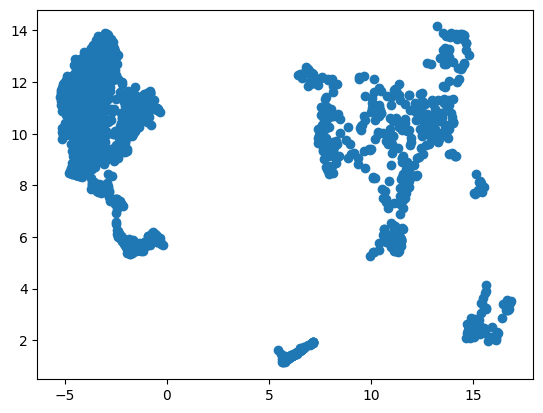

In [103]:
iso_forest = IsolationForest(n_estimators = 350, random_state = 42, contamination = contamination)
X_train_iso_red = reducer.transform(tf.squeeze(X_train_iso))
plt.scatter(X_train_iso_red[:, 0], X_train_iso_red[:, 1], cmap = "Spectral")

In [104]:
Conviso2 = ifd.create_and_train_ConvISO(model, iso_forest, X_train_iso)

In [105]:
iso_output_2 = Conviso2.pre_iso_model(X_train)
iso_pred_2 = Conviso2.ISO_model.predict(iso_output_2)

In [106]:
cm = confusion_matrix(y_train, np.where(iso_pred_2 == -1, 1, 0))
f1_score(y_train, np.where(iso_pred_2 == -1, 1, 0))

0.3670647391577624

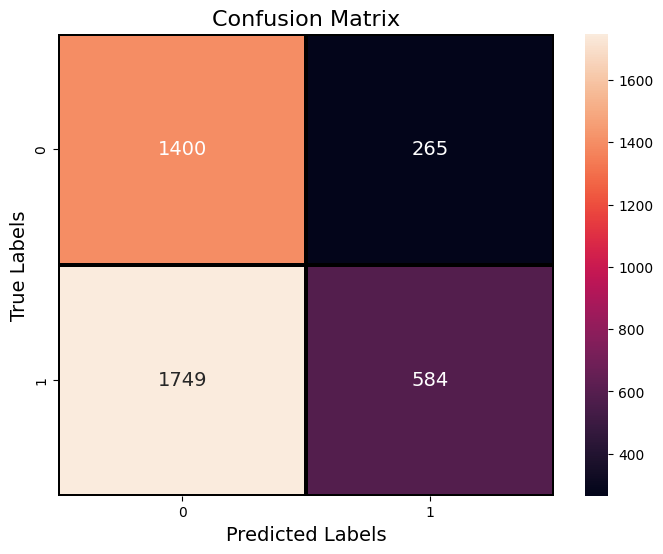

In [107]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cbar = True,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

<ipython-input-108-3143e76a2087>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_anomalies_sep_red[:, 0], X_anomalies_sep_red[:, 1], cmap = "Spectral")


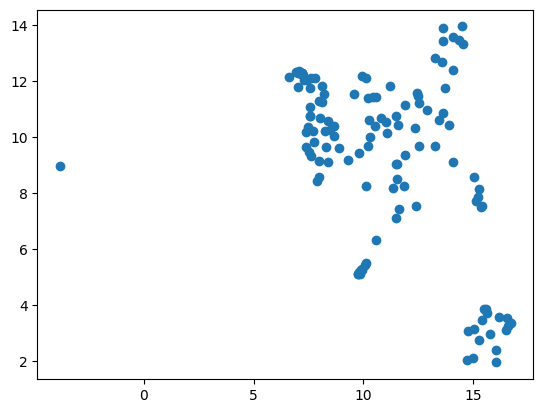

In [108]:
#lets create more effective dataset for  isolation forest using kmeans_plusplus to get farthest point in dataset
X_anomalies_sep, _ = kmeans_plusplus(np.array(tf.squeeze(X_anomalies_pre)), n_clusters = int(0.055*len(X_anomalies_pre)))
X_anomalies_sep = tf.convert_to_tensor(X_anomalies_sep)
X_anomalies_sep = tf.expand_dims(X_anomalies_sep, axis = -1)
X_anomalies_sep_red = reducer.transform(tf.squeeze(X_anomalies_sep))
plt.scatter(X_anomalies_sep_red[:, 0], X_anomalies_sep_red[:, 1], cmap = "Spectral")

In [109]:
#lets create dataset with normal points too!!
X_train_iso_2 = tf.concat([X_anomalies_sep, X_normal], axis = 0)
X_train_iso_2 = tf.random.shuffle(X_train_iso_2)
contamination2 =  len(X_anomalies_sep)/len(X_train_iso_2)
contamination2

0.07138873396542109

<ipython-input-110-ecd71b0b0613>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_normal_red[:, 0], X_normal_red[:, 1], cmap = "Spectral")


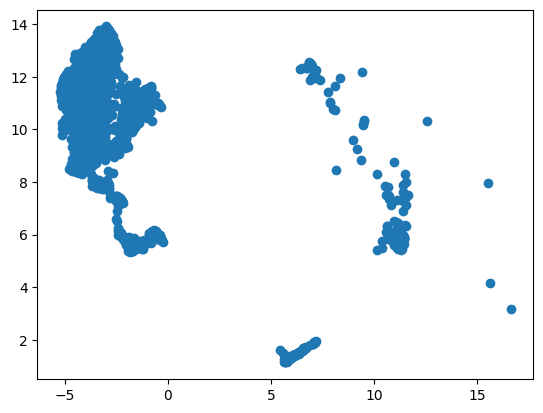

In [110]:
X_normal_red = reducer.transform(tf.squeeze(X_normal))
plt.scatter(X_normal_red[:, 0], X_normal_red[:, 1], cmap = "Spectral")

<ipython-input-111-b327f1461c22>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_iso_2_red[:, 0], X_train_iso_2_red[:, 1], cmap = "Spectral")


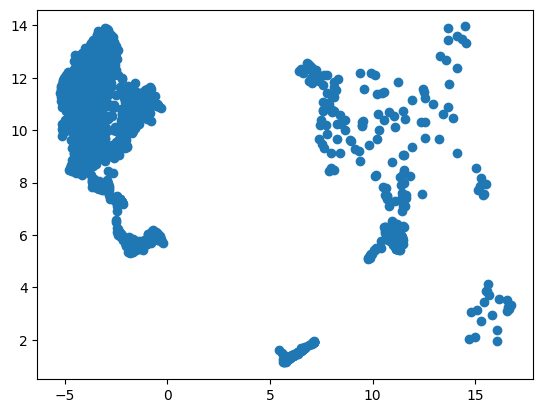

In [111]:
X_train_iso_2_red = reducer.transform(tf.squeeze(X_train_iso_2))
plt.scatter(X_train_iso_2_red[:, 0], X_train_iso_2_red[:, 1], cmap = "Spectral")

In [112]:
iso_forest = IsolationForest(n_estimators = 350, random_state = 42, contamination = 0.2)
Conviso3 = ifd.create_and_train_ConvISO(model, iso_forest, X_train_iso_2)

In [113]:
iso_output_3 = Conviso3.pre_iso_model(X_train)
iso_pred_3 = Conviso3.ISO_model.predict(iso_output_3)

In [114]:
cm = confusion_matrix(y_train, np.where(iso_pred_3 == -1, 1, 0))
f1_score(y_train, np.where(iso_pred_3 == -1, 1, 0))

0.8885062419285407

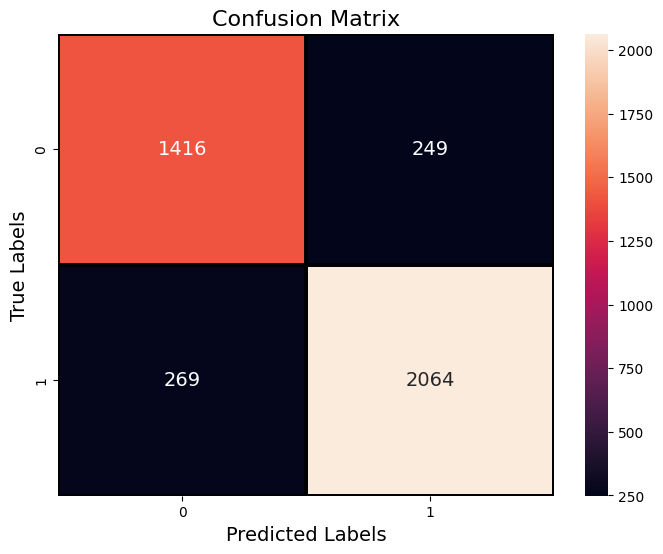

In [115]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cbar = True,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

###Using  SVM

In [116]:
X_train_svm = tf.gather(X_train, tf.where(y_train == 0)[:, 0])

In [117]:
X_train_svm

<tf.Tensor: shape=(1665, 140, 1), dtype=float64, numpy=
array([[[0.5897463 ],
        [0.63495192],
        [0.56035766],
        ...,
        [0.3379652 ],
        [0.37896403],
        [0.41542167]],

       [[0.47751352],
        [0.45991535],
        [0.30873102],
        ...,
        [0.62554027],
        [0.58558589],
        [0.51376626]],

       [[0.55535031],
        [0.51177331],
        [0.31398601],
        ...,
        [0.29011523],
        [0.42274018],
        [0.40795457]],

       ...,

       [[0.63284443],
        [0.68330828],
        [0.62672118],
        ...,
        [0.53924695],
        [0.48592347],
        [0.4469049 ]],

       [[0.5932317 ],
        [0.59425296],
        [0.45065838],
        ...,
        [0.48486439],
        [0.56162615],
        [0.5219022 ]],

       [[0.52444916],
        [0.48341841],
        [0.28728345],
        ...,
        [0.25656118],
        [0.36899361],
        [0.34701134]]])>

In [118]:
svm = ocsvm(degree = 4, gamma = 0.01, nu = 0.01, kernel = "poly", verbose = True)
ConvSVM = ifd.create_and_train_ConvSVM(model, svm, X_train_svm)

[LibSVM]

In [119]:
svm_output = ConvSVM.pre_svm_model(X_test)
pred_svm = ConvSVM.SVM_model.predict(svm_output)
pred_svm = np.where(pred_svm == -1, 1, 0)

###Using Attention Mechanism on Autoencoder

In [120]:
"Attention mechanism in progress"

'Attention mechanism in progress'